## Forecasting 

In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import seaborn as sns
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()


Reading the data

In [2]:
raw_data = yfinance.download (tickers = "^GSPC ^FTSE ^N225 ^GDAXI", start = "1994-01-07", end = "2018-01-29", 
                              interval = "1d", group_by = 'ticker', auto_adjust = True, treads = True)

[*********************100%***********************]  4 of 4 completed


In [3]:
df = raw_data.copy()
df.shape

(6260, 20)

In [4]:
df['spx'] = df['^GSPC'].Close[:]
df['dax'] = df['^GDAXI'].Close[:]
df['ftse'] = df['^FTSE'].Close[:]
df['nikkei'] = df['^N225'].Close[:]

In [5]:
df = df.iloc[1:]
del df['^N225']
del df['^GSPC']
del df['^GDAXI']
del df['^FTSE']
df=df.asfreq('b')
df=df.fillna(method='ffill')

creating a returns 

In [6]:
df['ret_spx'] = df.spx.pct_change(1)*100
df['ret_ftse'] = df.ftse.pct_change(1)*100
df['ret_dax'] = df.dax.pct_change(1)*100
df['ret_nikkei'] = df.nikkei.pct_change(1)*100

Splitting the data

In [7]:
size = int(len(df)*0.8)
df, df_test = df.iloc[:size], df.iloc[size:]
print(f"Train size: {len(df)}, Test Size: {len(df_test)}")

Train size: 5020, Test Size: 1256


Fitting the model

In [8]:
model_arima = ARIMA(df.ftse, order=(1,0,0))
result_arima = model_arima.fit()

Forecasting 

In [9]:
df_test.tail()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei
,,,,,,,,
Date,,,,,,,,
2018-01-23,2839.129883,13559.599609,7731.799805,24124.150391,0.217437,0.212561,0.712354,1.292476
2018-01-24,2837.540039,13414.740234,7643.399902,23940.779297,-0.055998,-1.143329,-1.068316,-0.760114
2018-01-25,2839.250000,13298.360352,7615.799805,23669.490234,0.060262,-0.361097,-0.867552,-1.133167
2018-01-26,2872.870117,13340.169922,7665.500000,23631.880859,1.184120,0.652593,0.314396,-0.158894
2018-01-29,2872.870117,13340.169922,7665.500000,23629.339844,0.000000,0.000000,0.000000,-0.010752


In [10]:
start_date = "2013-04-08"
end_date = "2014-01-01"

In [11]:
# end_date = "2015-01-01"
df_pred = result_arima.predict(start = start_date, end = end_date)

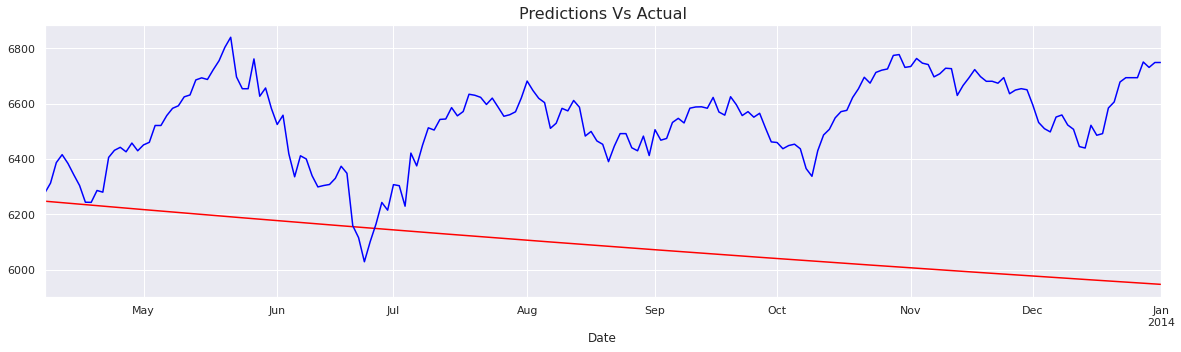

In [12]:
df_pred[start_date:end_date].plot(figsize=(20,5), color = 'red')
df_test.ftse[start_date:end_date].plot(color = 'blue')
plt.title("Predictions Vs Actual", size=16)
plt.show()

We see a constantly decreasing line, which isn't at all realistic in practice, we don't expect prices to be constantly declining. That would mean the price today is as high as it's ever going to be and the price tomorrow will always be lower if that was the case.

**The issue here comes from our model of choice. Because we're using a simple AR model, the predictions are only based on the constant and the prices from the previous period.**

Lets forecast returns 

In [13]:
model_arima_ret_ftse = ARIMA(df.ret_ftse[1:], order=(1,0,0))
result_arima_ret_ftse = model_arima_ret_ftse.fit()

df_pred_ret = result_arima_ret_ftse.predict(start=start_date, end=end_date)

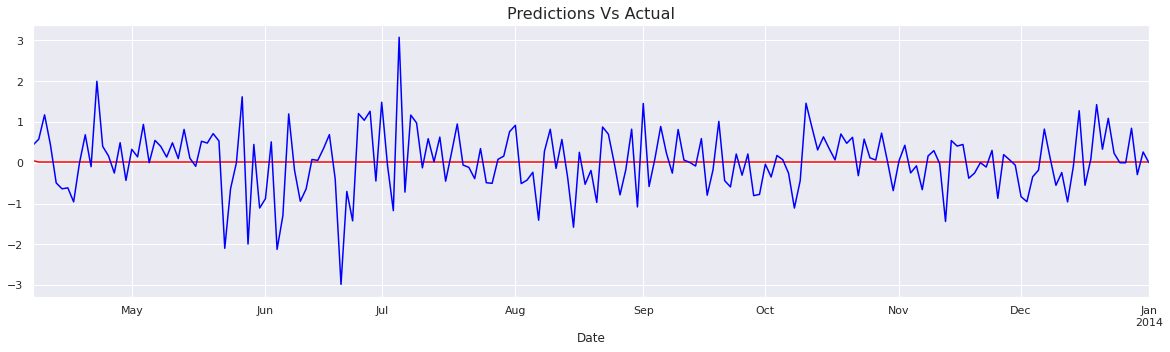

In [14]:
df_pred_ret[start_date:end_date].plot(figsize=(20,5), color = 'red')
df_test.ret_ftse[start_date:end_date].plot(color = 'blue')
plt.title("Predictions Vs Actual", size=16)
plt.show()

After we plot the graph, we see what appears to be a constant line at the zero, this means that our model makes no predictions since it assumes all future returns will be zero or extremely close to it. This tells us that the coefficients for the pass values, as well as the values themselves, must have low, absolute values.

In [15]:
result_arima_ret_ftse.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 5019
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -7928.807
Date:                Wed, 24 Aug 2022   AIC                          15863.615
Time:                        21:03:44   BIC                          15883.178
Sample:                    01-11-1994   HQIC                         15870.470
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.145      0.252      -0.013       0.051
ar.L1         -0.0230      0.009     -2.694      0.007      -0.040      -0.006
sigma2         1.3794      0.014    100.059      0.000       1.352       1.406
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              7861.87
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MA

In [16]:
model_ma_ret_ftse = ARIMA(df.ret_ftse[1:], order=(0,0,1))
result_ma_ret_ftse = model_ma_ret_ftse.fit()

df_ma_pred_ret = result_ma_ret_ftse.predict(start=start_date, end=end_date)

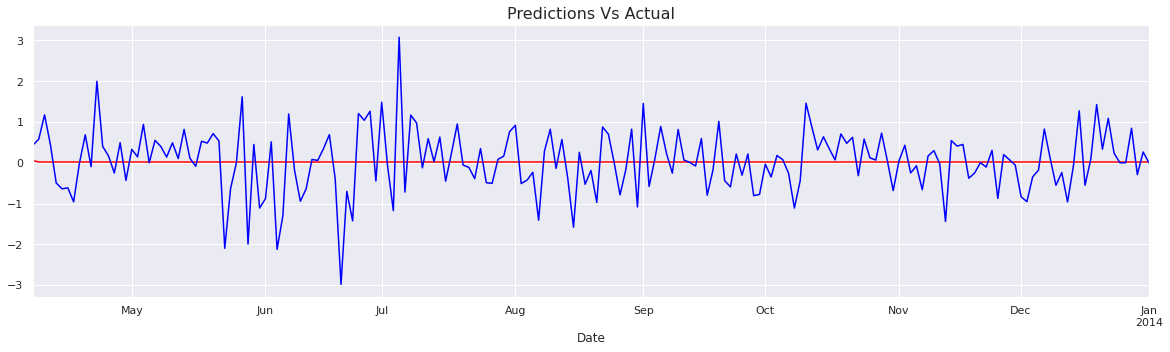

In [17]:
df_ma_pred_ret[start_date:end_date].plot(figsize=(20,5), color = 'red')
df_test.ret_ftse[start_date:end_date].plot(color = 'blue')
plt.title("Predictions Vs Actual", size=16)
plt.show()

In [18]:
df_ma_pred_ret.head()

2013-04-08    0.058337
2013-04-09    0.018805
2013-04-10    0.018805
2013-04-11    0.018805
2013-04-12    0.018805
Freq: B, Name: predicted_mean, dtype: float64

we spot that all the values after the first period don't change, but why is that? Is it because the error terms going forward, don't exist, is it because the coefficient is so small, we're essentially only left with a constant after the initial few time periods

ARMA

In [19]:
model_arma_ret = ARIMA(df.ret_ftse[1:], order=(1,0,1))
result_arma_ret = model_arma_ret.fit()

df_arma_pred_ret = result_arma_ret.predict(start=start_date, end=end_date)

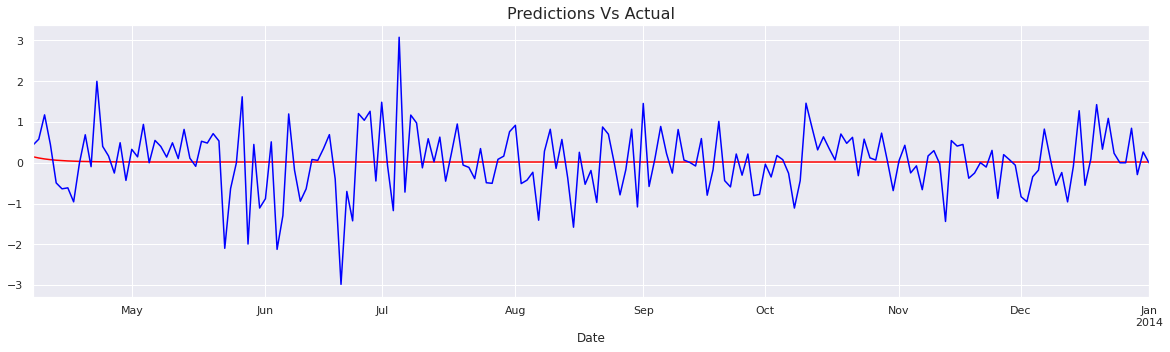

In [20]:
df_arma_pred_ret[start_date:end_date].plot(figsize=(20,5), color = 'red')
df_test.ret_ftse[start_date:end_date].plot(color = 'blue')
plt.title("Predictions Vs Actual", size=16)
plt.show()

We see a repetition of what we had for the simple R and models, a very consistent line of predictions that looks constant from afar.

ARMAX

In [21]:
model_armax_ret = ARIMA(df.ret_ftse[1:], exog=df[['ret_spx','ret_dax','ret_nikkei']][1:], order=(1,0,1))
result_armax_ret = model_armax_ret.fit()

df_armax_pred_ret = result_armax_ret.predict(start=start_date, end=end_date, exog=df_test[['ret_spx','ret_dax','ret_nikkei']][start_date:end_date])

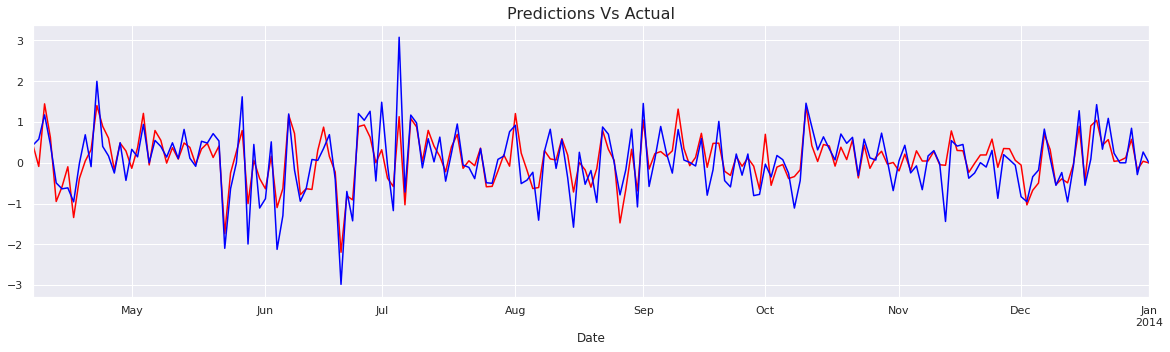

In [22]:
df_armax_pred_ret[start_date:end_date].plot(figsize=(20,5), color = 'red')
df_test.ret_ftse[start_date:end_date].plot(color = 'blue')
plt.title("Predictions Vs Actual", size=16)
plt.show()

Finally see that our predictions match the true values a lot more closely than ever before. In some instances, the model overshoots the predictions, in others, it underestimates the possible jumps, but overall, it follows the data really well. This indicates that including outside factors like other market value indexes, improved the predictive power dramatically

*Why*

A simple explanation is that regular ARMA models can't incorporate any outside real world effects by including other market indices, we're allowing the model to take into account data from today, as well as information from past periods. This is extremely useful because it makes estimations a lot more precise, as we can clearly see. However, there is a downside to max models. They can make forecasting impossible. 

**Prediction Vs. Forecast**

- $Prediction$ : In-sample estimation,
- $Forecasting$ : out-of-sample estimation 

The exogenous values are not available for forecasting. Hence, Max models are great for analyzing the data but not for forecasting.

In [23]:
result_armax_ret.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 5019
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -5322.153
Date:                Wed, 24 Aug 2022   AIC                          10658.306
Time:                        21:03:47   BIC                          10703.952
Sample:                    01-11-1994   HQIC                         10674.301
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0043      0.008     -0.542      0.588      -0.020       0.011
('ret_spx', '')        0.1049      0.006     16.654      0.000       0.093       0.117
('ret_dax', '')        0.5481      0.005     99.942      0.000       0.537       0.559
('ret_nikkei', '')     0.0760      0.005     15.630      0.000       0.066       0.085
ar.L1                  0.4244      0.055      7.766      0.000       0.317       0.532
ma.L1                 -0.5445      0.053    -10.241      0.000      -0.649      -0.440
sigma2                 0.4882      0.005     91.110      0.000       0.478       0.499
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):             12045.13
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             0.24
Prob(H) (two-sided):                  0.15   Kurtosis:                        10.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARIMA

In [24]:
model_arima = ARIMA(df.ftse, order=(6,1,3))
result_arima = model_arima.fit()


df_arima_pred = result_arima.predict(start=start_date, end=end_date)

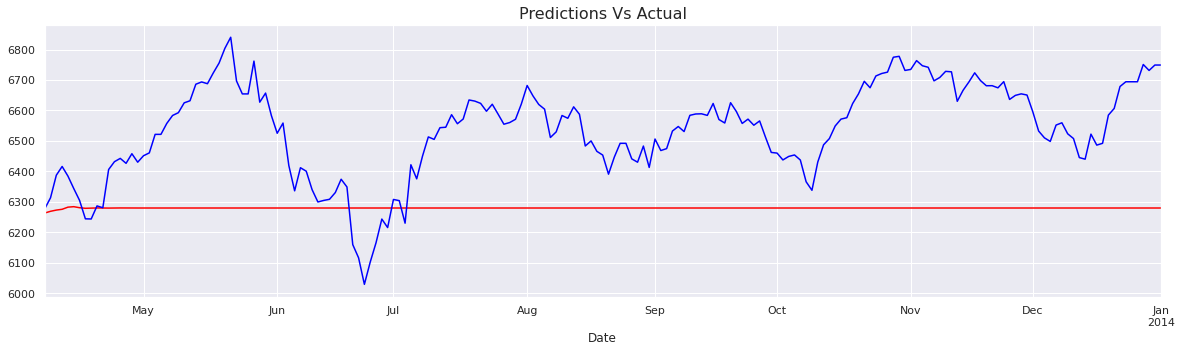

In [25]:
df_arima_pred[start_date:end_date].plot(figsize=(20,5), color = 'red')
df_test.ftse[start_date:end_date].plot(color = 'blue')
plt.title("Predictions Vs Actual", size=16)
plt.show()

This is trivial model.

SARMA

In [26]:
model_ret_sarma = SARIMAX(df.ret_ftse[1:], order=(3,0,4), seasonal_order=(3,0,2,5))
result_ret_sarma = model_ret_sarma.fit()

df_sarma_predict = result_ret_sarma.predict(start=start_date, end=end_date)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57194D+00    |proj g|=  2.04767D-02


 This problem is unconstrained.



At iterate    5    f=  1.57171D+00    |proj g|=  2.94646D-03

At iterate   10    f=  1.57117D+00    |proj g|=  7.69324D-03

At iterate   15    f=  1.57112D+00    |proj g|=  3.52613D-04

At iterate   20    f=  1.57106D+00    |proj g|=  7.53125D-03

At iterate   25    f=  1.57097D+00    |proj g|=  6.73552D-04

At iterate   30    f=  1.57096D+00    |proj g|=  2.35456D-03

At iterate   35    f=  1.57091D+00    |proj g|=  2.73336D-03

At iterate   40    f=  1.57082D+00    |proj g|=  1.32052D-03

At iterate   45    f=  1.57055D+00    |proj g|=  3.04696D-02

At iterate   50    f=  1.56983D+00    |proj g|=  9.96339D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

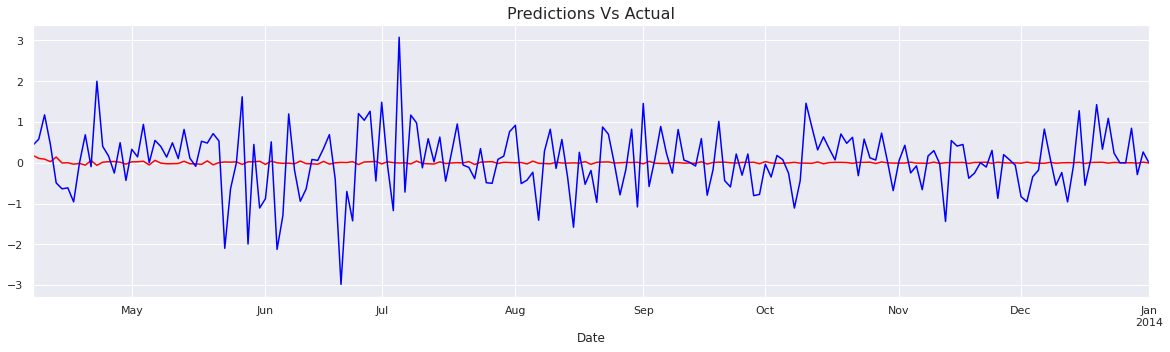

In [27]:
df_sarma_predict[start_date:end_date].plot(figsize=(20,5), color = 'red')
df_test.ret_ftse[start_date:end_date].plot(color = 'blue')
plt.title("Predictions Vs Actual", size=16)
plt.show()

SARIMAX

In [28]:
model_ret_sarimax = SARIMAX(df.ret_ftse[1:], order=(3,0,4), seasonal_order=(3,0,2,5), exog=df[['ret_spx','ret_dax','ret_nikkei']][1:])
result_ret_sarimax = model_ret_sarimax.fit()

df_sarimax_predict = result_ret_sarimax.predict(start=start_date, end=end_date, exog=df_test[['ret_spx','ret_dax','ret_nikkei']][start_date:end_date])

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05704D+00    |proj g|=  3.09923D-02

At iterate    5    f=  1.05642D+00    |proj g|=  1.67546D-03

At iterate   10    f=  1.05640D+00    |proj g|=  4.32443D-03

At iterate   15    f=  1.05630D+00    |proj g|=  5.22036D-03

At iterate   20    f=  1.05629D+00    |proj g|=  1.90474D-04

At iterate   25    f=  1.05628D+00    |proj g|=  2.36569D-03

At iterate   30    f=  1.05604D+00    |proj g|=  4.52123D-03

At iterate   35    f=  1.05601D+00    |proj g|=  8.47571D-04

At iterate   40    f=  1.05601D+00    |proj g|=  9.35328D-04

At iterate   45    f=  1.05598D+00    |proj g|=  1.53272D-03

At iterate   50    f=  1.05598D+00    |proj g|=  1.33702D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

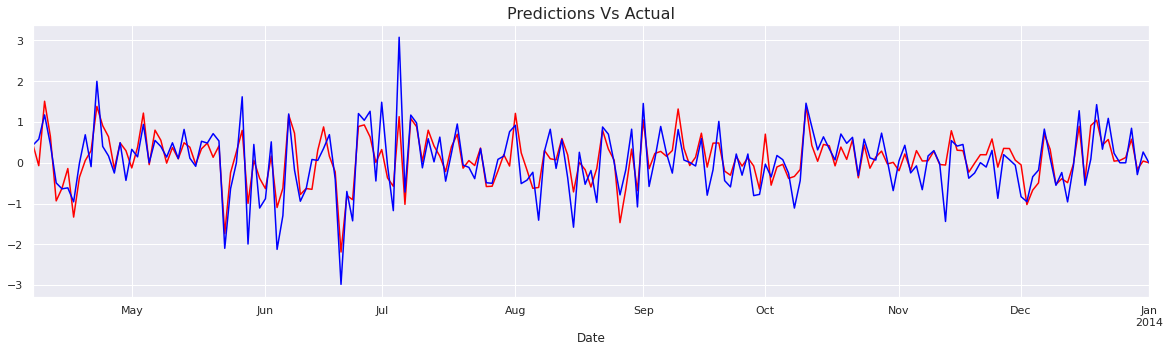

In [29]:
df_sarimax_predict[start_date:end_date].plot(figsize=(20,5), color = 'red')
df_test.ret_ftse[start_date:end_date].plot(color = 'blue')
plt.title("Predictions Vs Actual", size=16)
plt.show()

Once again, we can see a curve that follows the data very closely, a similar improvement occurred when we went from the ARMA to the ARMAX, so adding exogenous variables drastically changes our predictions.

Auto ARIMA

In [30]:
model_auto_arima = auto_arima(df.ret_ftse[1:])

In [31]:
# predicting and converting the data  from np array to df
df_auto_arima_pred = pd.DataFrame(model_auto_arima.predict(n_periods=len(df_test[start_date:end_date])), index=df_test[start_date:end_date].index)
df_auto_arima_pred.head()

,0
Date,
2013-04-08,0.223930
2013-04-09,0.050021
2013-04-10,0.098894
2013-04-11,0.038774
2013-04-12,0.127782


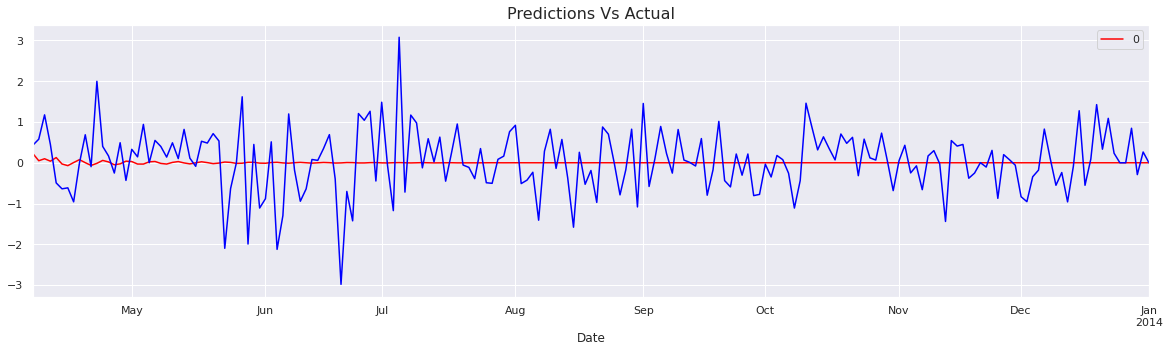

In [32]:
df_auto_arima_pred[start_date:end_date].plot(figsize=(20,5), color = 'red')
df_test.ret_ftse[start_date:end_date].plot(color = 'blue')
plt.title("Predictions Vs Actual", size=16)
plt.show()

In [36]:
model_auto_arima_opt = auto_arima(df.ret_ftse[1:], exogenous = df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:], m = 7,
                       max_p = 7, max_q = 7, max_P = 7, max_Q = 7)

df_auto_arima_pred_opt = pd.DataFrame(model_auto_arima_opt.predict(n_periods=len(df_test[start_date:end_date]), 
                          exogenous = df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date]), 
                          index=df_test[start_date:end_date].index
                        )
                        
df_auto_arima_pred_opt.head()

,0
Date,
2013-04-08,0.223930
2013-04-09,0.050021
2013-04-10,0.098894
2013-04-11,0.038774
2013-04-12,0.127782


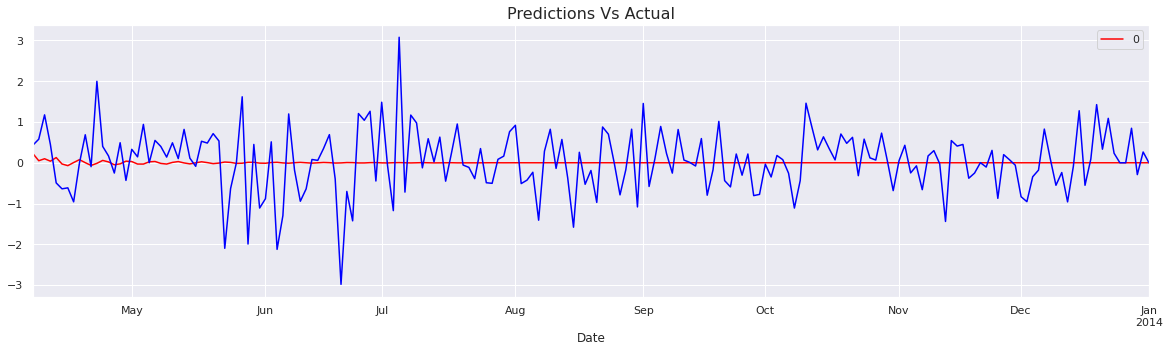

In [37]:
df_auto_arima_pred_opt.plot(figsize=(20,5), color = 'red')
df_test.ret_ftse[start_date:end_date].plot(color = 'blue')
plt.title("Predictions Vs Actual", size=16)
plt.show()

In [38]:
model_auto_full = auto_arima(df.ret_ftse[1:], exogenous = df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:], m = 5,
                       max_order = None, max_p = 7, max_q = 7, max_d = 2, max_P = 4, max_Q = 4, max_D = 2,
                       maxiter = 50, alpha = 0.05, n_jobs = -1, trend = 'ct', information_criterion = 'oob',
                       out_of_sample = int(len(df)*0.2)
                    )

In [39]:
df_auto_arima_pred_full = pd.DataFrame(model_auto_full.predict(n_periods=len(df_test[start_date:end_date]), 
                          exogenous = df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date]), 
                          index=df_test[start_date:end_date].index
)

In [ ]:
df_auto_arima_pred_full.plot(figsize=(20,5), color = 'red')
df_test.ret_ftse[start_date:end_date].plot(color = 'blue')
plt.title("Predictions Vs Actual", size=16)
plt.show()